This notebook performs response-weighted analysis on the activation outputs of a traditional MNIST model.

# Initialisations

In [71]:
# import argparse
from rwa import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.metrics import mutual_info_score
import pickle

In [17]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(10*10*64, 128)  
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x1 = self.conv1(x)
        x = F.relu(x1)
        x2 = self.conv2(x)
        x = F.relu(x2)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return x1, x2

In [18]:
net = Net()
net.eval()
modelfilename = './model_data/mnist_model/mnist_cnn.pt'
net.load_state_dict(torch.load(modelfilename)) # load the model
print(net)
print(net.state_dict().keys())

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


# Weights Visualisation

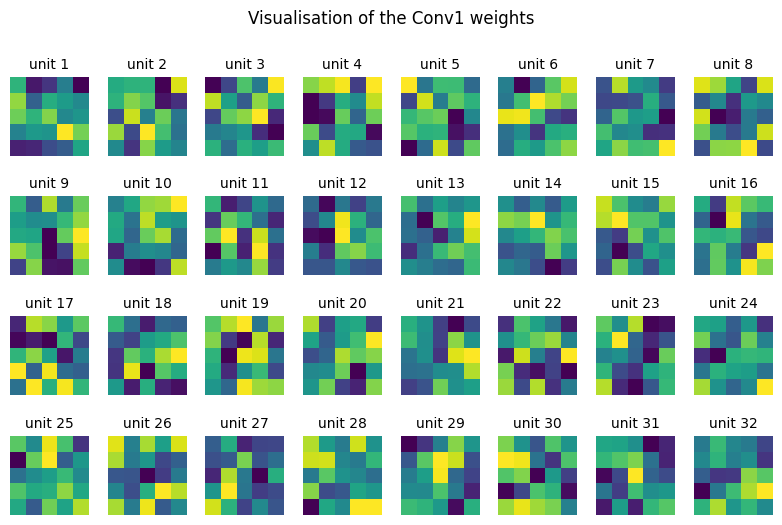

In [19]:
# conv1 weights (kernels) visualisation - 16 units
w1 = net.state_dict()['conv1.weight']
w1 = np.transpose(w1, (0, 2, 3, 1)) # transform to visualisation format in rgb state

# visualise the weights as RGB images
for i in range(w1.shape[0]): # loop through each unit
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    to_show = (w1[i] - w1[i].min()) / (w1[i].max() - w1[i].min()) # normalise to [0, 1]
    plt.imshow(to_show)
    plt.title('unit ' + str(i+1), fontsize=10)
plt.suptitle('Visualisation of the Conv1 weights')
plt.tight_layout()
plt.gcf().set_size_inches(8, 5.5)
plt.show()

# Lab Recording Room

In [21]:
# experiment settings
NBatches = 50
BSize = 1000
zeroMean = True
layer = 'conv1'

In [22]:
act_conv1, noise1 = MnistActRecorder(layer, net, batch_num=NBatches, batch_size=BSize, zero_mean=zeroMean)
print(noise1.min(), noise1.max(), noise1.mean())

100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


Activation recording completed


100%|██████████| 32/32 [00:00<00:00, 98.62it/s] 


Shape of activation response list: torch.Size([32, 50000])
Shape of noise list: torch.Size([50000, 28, 28, 1])
tensor(-127.5000) tensor(127.5000) tensor(0.0083)


In [23]:
# save the activation and noise data
torch.save(act_conv1, './rwa_data/mnist/mnist_rand_0mean/act1.pt')
torch.save(noise1, './rwa_data/mnist/mnist_rand_0mean/noise1.pt')

# Conv1 - Zero Mean [-127.5, 127,5]

In [7]:
# load existing data if already recorded
act_conv1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/act1.pt')
noise1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/noise1.pt')
rf1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/rf1.pt')
# correlation1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/correlation1.pt')
# rf_cropped1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/rf_cropped1.pt')
# cov1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/cov1.pt')
# eigen1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/eigen1.pt')

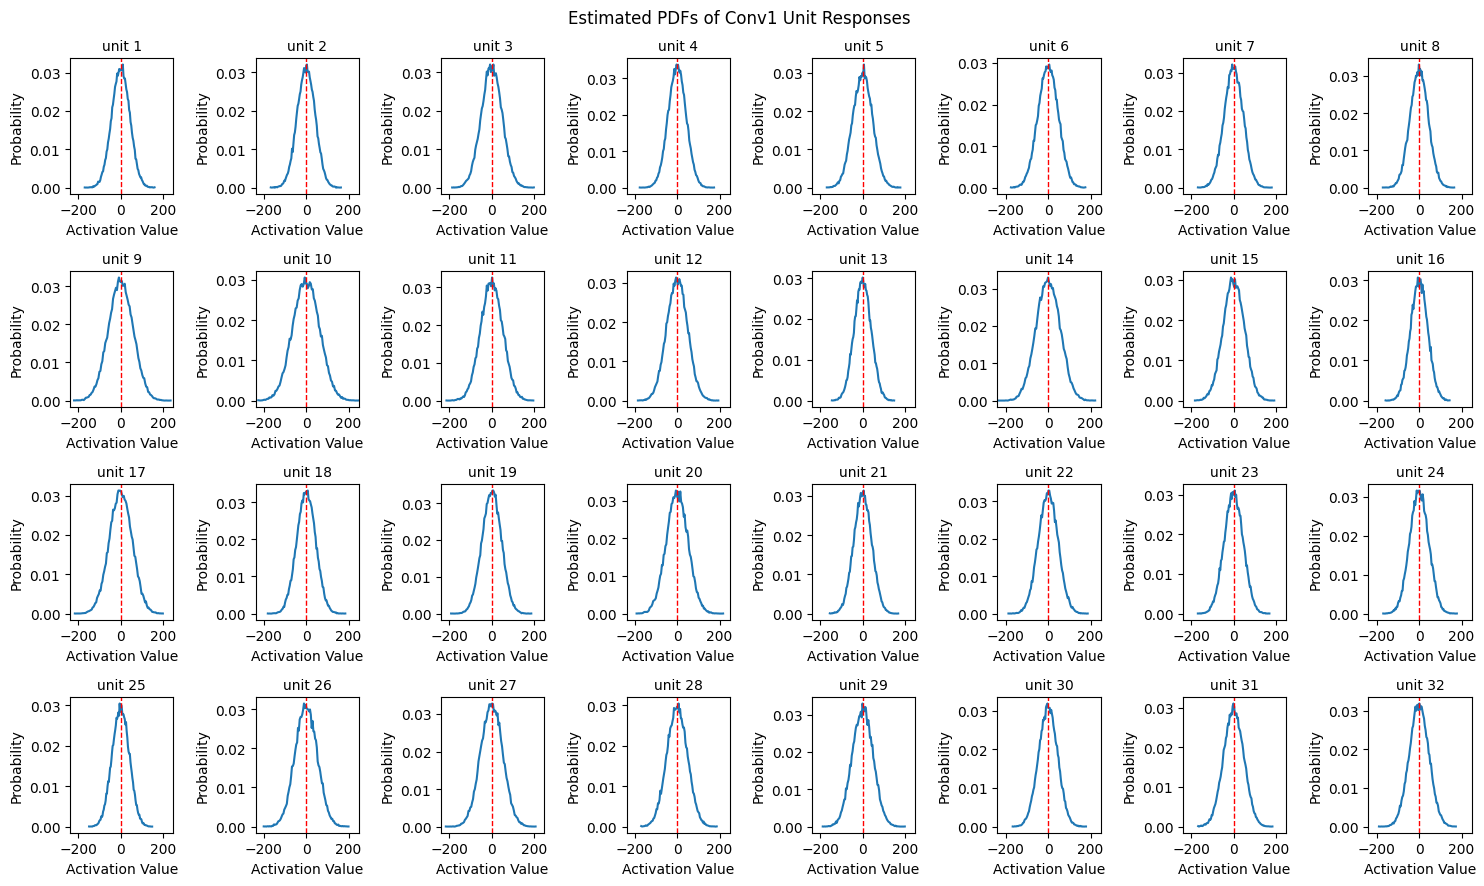

In [24]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 9)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 9)
plt.show()

RWA

In [25]:
# RWA
rf1 = RWA(act_conv1, noise1)
# adjust dimensions of rf1 from 3 channels to 1 channel for mnist
rf1 = rf1[:,:,:,0]

100%|██████████| 1600000/1600000 [00:43<00:00, 36535.63it/s]

Shape of receptive field list: torch.Size([32, 28, 28, 1])


In [28]:
# Save the RWA data
torch.save(rf1, './rwa_data/mnist/mnist_rand_0mean/rf1.pt')

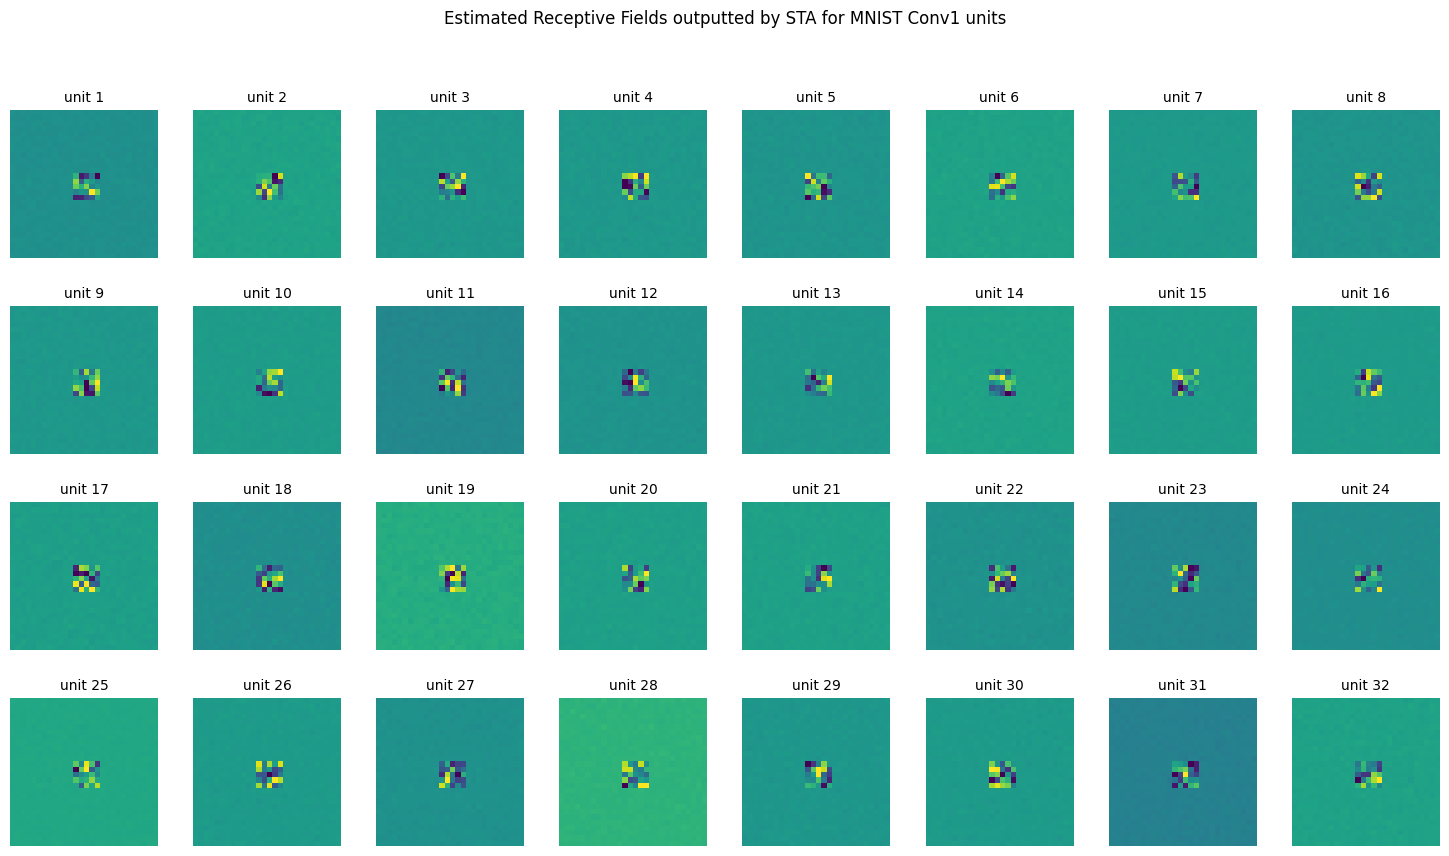

In [29]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for MNIST Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 9)
plt.show()

Correlation

In [30]:
correlation1 = CorrLoc(noise1, act_conv1)

100%|██████████| 25088/25088 [00:23<00:00, 1086.44it/s]


In [31]:
# Save the correlation data
torch.save(correlation1, './rwa_data/mnist/mnist_rand_0mean/correlation1.pt')

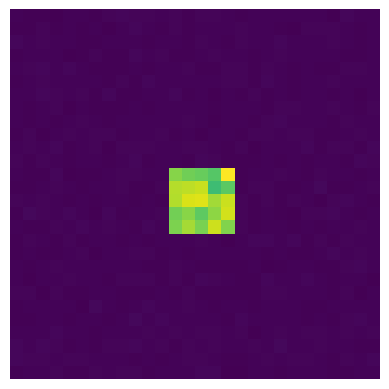

In [32]:
# Visualise the correlation output as image plots (superposed RFs of all units)
to_show = correlation1
to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
plt.axis('off')
plt.imshow(to_show)

In [33]:
# crop the correlation output to get the RFs
rf_cropped1, mask1 = RfCrop(correlation1, rf1)

In [34]:
# Save the cropped rf data
torch.save(rf_cropped1, './rwa_data/mnist/mnist_rand_0mean/rf_cropped1.pt')

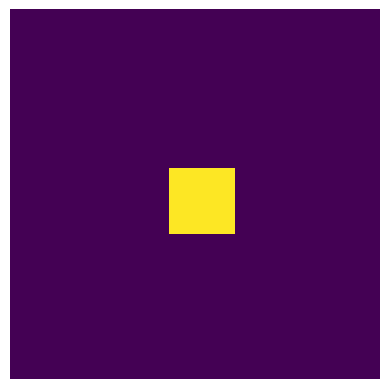

In [35]:
to_show = mask1
plt.axis('off')
plt.imshow(to_show)

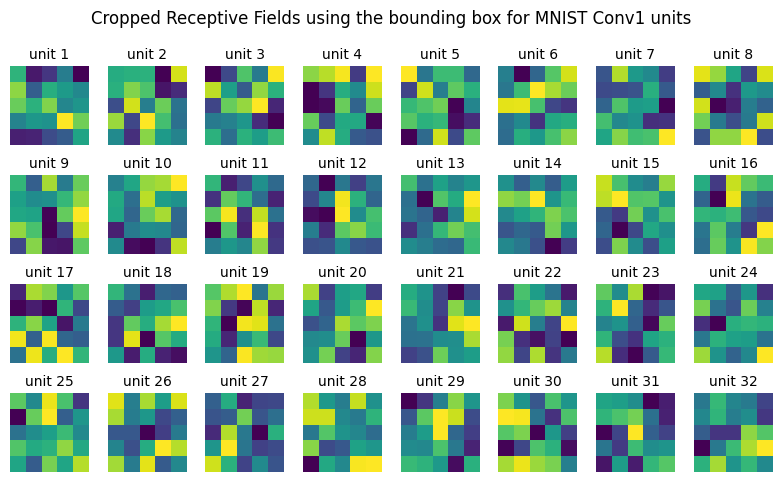

In [70]:
# Visualise the RWA output as image plots
for i in range(rf_cropped1.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((28, 28, 1)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Cropped Receptive Fields using the bounding box for MNIST Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(8, 5)
plt.show()

Mutual Information

In [41]:
print(noise1[:, 0, 0].flatten().shape) # one pixel noise
print(act_conv1[0].flatten().shape) # one unit activation

torch.Size([50000])
torch.Size([50000])


In [103]:
num_units = act_conv1.shape[0]
rf = np.zeros((num_units, noise1.shape[1], noise1.shape[2])) # single channel

with tqdm(total = num_units * noise1.shape[1] * noise1.shape[2]) as pbar:
    for i in range(num_units):
        for j in range(noise1.shape[1]):
            for k in range(noise1.shape[2]): # go through each pixel
                rf[i, j, k] = mutual_info_regression(noise1[:, j, k], act_conv1[i].flatten())[0]
                pbar.update(1)


100%|██████████| 1568/1568 [09:04<00:00,  2.88it/s]


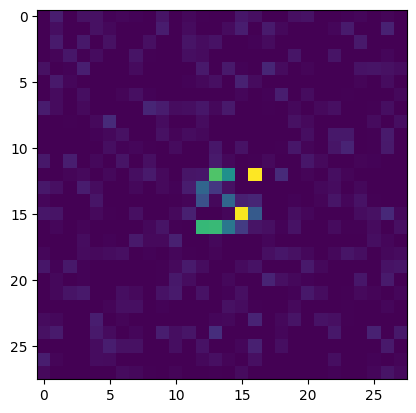

In [106]:
x = rf[0]
x = (x - x.min()) / (x.max() - x.min()) # normalise to [0, 1]
plt.imshow(x)

In [116]:
# round every number in noise1 to nearest whole number
noise1_ = np.round(noise1)
act_conv1_ = np.round(act_conv1)

In [120]:
num_units = act_conv1.shape[0]
rf = np.zeros((num_units, noise1.shape[1], noise1.shape[2])) # single channel

with tqdm(total = num_units * noise1.shape[1] * noise1.shape[2]) as pbar:
    for i in range(num_units):
        for j in range(noise1.shape[1]):
            for k in range(noise1.shape[2]): # go through each pixel
                rf[i, j, k] = mutual_info_score(noise1_[:, j, k].flatten(), act_conv1_[i].flatten())
                pbar.update(1)

100%|██████████| 25088/25088 [09:57<00:00, 42.01it/s]


In [123]:
# crop the correlation output to get the RFs
rf_cropped, __ = RfCrop(correlation1, torch.tensor(rf))

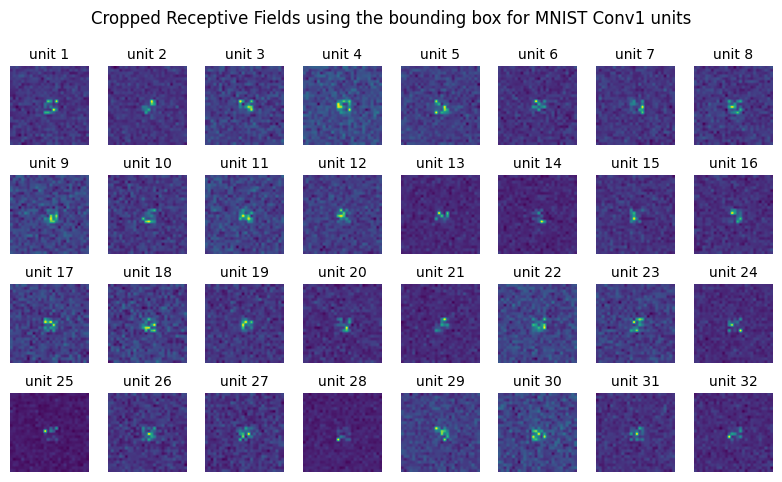

In [125]:
# Visualise the RWA output as image plots
for i in range(rf.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((28, 28, 1)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Cropped Receptive Fields using the bounding box for MNIST Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(8, 5)
plt.show()

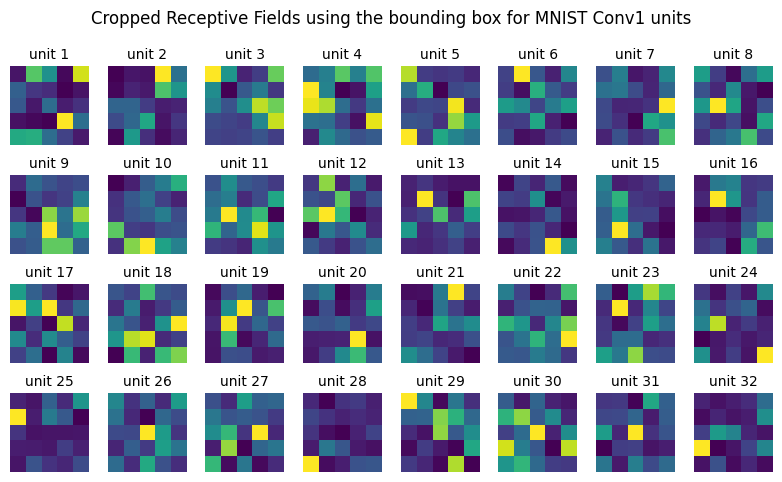

In [124]:
# Visualise the RWA output as image plots
for i in range(rf_cropped.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((28, 28, 1)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Cropped Receptive Fields using the bounding box for MNIST Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(8, 5)
plt.show()

RWC

In [14]:
# get cropped noise fields for RWC
noise_cropped1 = noise1[:,:,:,0]
noise_cropped1, _ = RfCrop(correlation1, noise_cropped1)

In [15]:
print(noise_cropped1.shape)
print(rf_cropped1.shape)

torch.Size([50000, 5, 5])
torch.Size([32, 5, 5])


In [54]:
noise_cropped1.shape[1]

5

In [55]:
# rwc
NUnits = rf_cropped1.shape[0]
cov = torch.zeros(NUnits, noise_cropped1.shape[1]*noise_cropped1.shape[2], noise_cropped1.shape[1]*noise_cropped1.shape[2])

# reshape rf and noise for RWC operations
rf = rf_cropped1.reshape(NUnits, -1)
noise = noise_cropped1.reshape(noise_cropped1.shape[0], -1)

# Normalise the RFs and noises to [0, 255] or [-127,5, 127.5] if zeroMean
for i in range(NUnits):
    if rf[i].any() != 0:
        if zeroMean:
            rf[i] = ((rf[i] - rf[i].min()) / (rf[i].max() - rf[i].min()) - 0.5) * 255
        else:
            rf[i] = (rf[i] - rf[i].min()) / (rf[i].max() - rf[i].min()) * 255

# RWC
with tqdm(total=NBatches*NUnits*BSize) as pbar:
    for i in range(NUnits):
        mu = rf[i]
        for j in range(noise.shape[0]):
            tmp = noise[j] - mu
            cov[i] += act_conv1[i, j] * tmp.unsqueeze(1) @ tmp.unsqueeze(0)
            pbar.update(1)
        cov[i] /= (act_conv1[i] != 0).sum()

100%|██████████| 1600000/1600000 [00:40<00:00, 39745.52it/s]


In [59]:
eigen = []
for i in range(NUnits):
    eigen.append(torch.linalg.eigh(cov[i, :, :]))

In [63]:
eigen1 = eigen

In [73]:
eigen1[0].eigenvalues

tensor([-2.0914e+06, -7.5113e+03, -6.9503e+03, -6.6439e+03, -6.1394e+03,
        -5.1626e+03, -4.1388e+03, -3.7364e+03, -2.8537e+03, -2.2084e+03,
        -1.8226e+03, -1.3120e+03, -2.2247e+02,  3.2803e+02,  5.4958e+02,
         1.3473e+03,  1.5280e+03,  2.5256e+03,  3.0426e+03,  3.7960e+03,
         4.7988e+03,  4.9936e+03,  6.4494e+03,  7.3681e+03,  7.8722e+03])

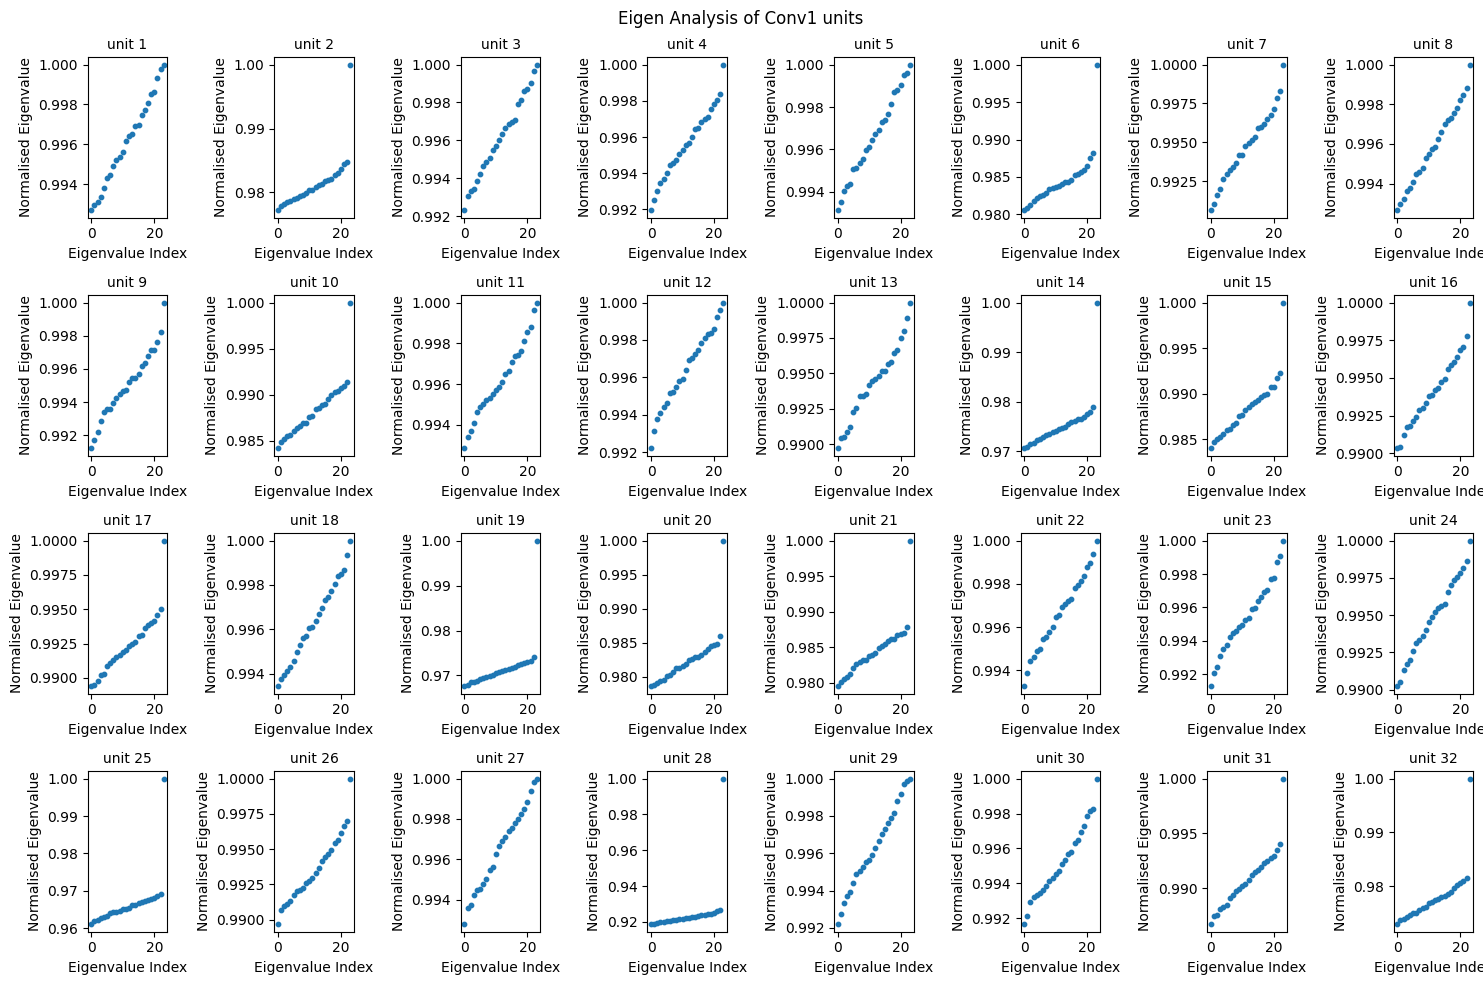

In [75]:
for i in range(len(eigen1)): # each unit
    plt.subplot(4, 8, i+1)
    
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # if list is not empty
        eigenvalues = eigen1[i].eigenvalues
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)-1), eigenvalues[1:], s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 10)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

In [77]:
eigen1[0].eigenvectors.shape

torch.Size([25, 25])

In [79]:
rf_cropped1.shape

torch.Size([32, 5, 5])

In [ ]:
# RWC
cov1 = RWC_mnist(layer, net, act_conv1, noise_cropped1, rf_cropped1, NBatches=NBatches, BSize=BSize, zeroMean=True)

In [10]:
torch.save(cov1, './rwa_data/mnist/mnist_rand_0mean/cov1.pt')

In [ ]:
# eigen analysis - conv1
NUnits = cov1.shape[0]
eigen1 = []
with tqdm(total=NUnits) as pbar:
    for i in range(NUnits):
        eigen1.append(eigenAnalysis(cov1, i))
        pbar.update(1)

In [9]:
# save the eigenvalues and eigenvectors
with open('./rwa_data/mnist/mnist_rand_0mean/eigen1.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

TypeError: len() of a 0-d tensor

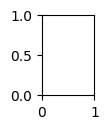

In [64]:
# conv1 eigenvalues

# plot the eigenvalues for each unit - all eigenvalues
for i in range(len(eigen1)): # each unit
    plt.subplot(4, 8, i+1)
    
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # if list is not empty
        eigenvalues = eigen1[i][0][0]
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)), eigenvalues, s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 10)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

plt.figure()
# plot the eigenvalues for each unit - exclude largest eigenvalues
for i in range(len(eigen1)): # each unit
    plt.subplot(4, 8, i+1)
    
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # if list is not empty
        eigenvalues = eigen1[i][0][0]
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)-1), eigenvalues[:-1], s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 10)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units - excludes largest eigenvalue')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

plt.figure()
# plot the eigenvalues for each unit - exclude smallest eigenvalues
for i in range(len(eigen1)): # each unit
    plt.subplot(4, 8, i+1)
    
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # if list is not empty
        eigenvalues = eigen1[i][0][0]
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)-1), eigenvalues[1:], s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 10)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units - excludes smallest eigenvalue')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

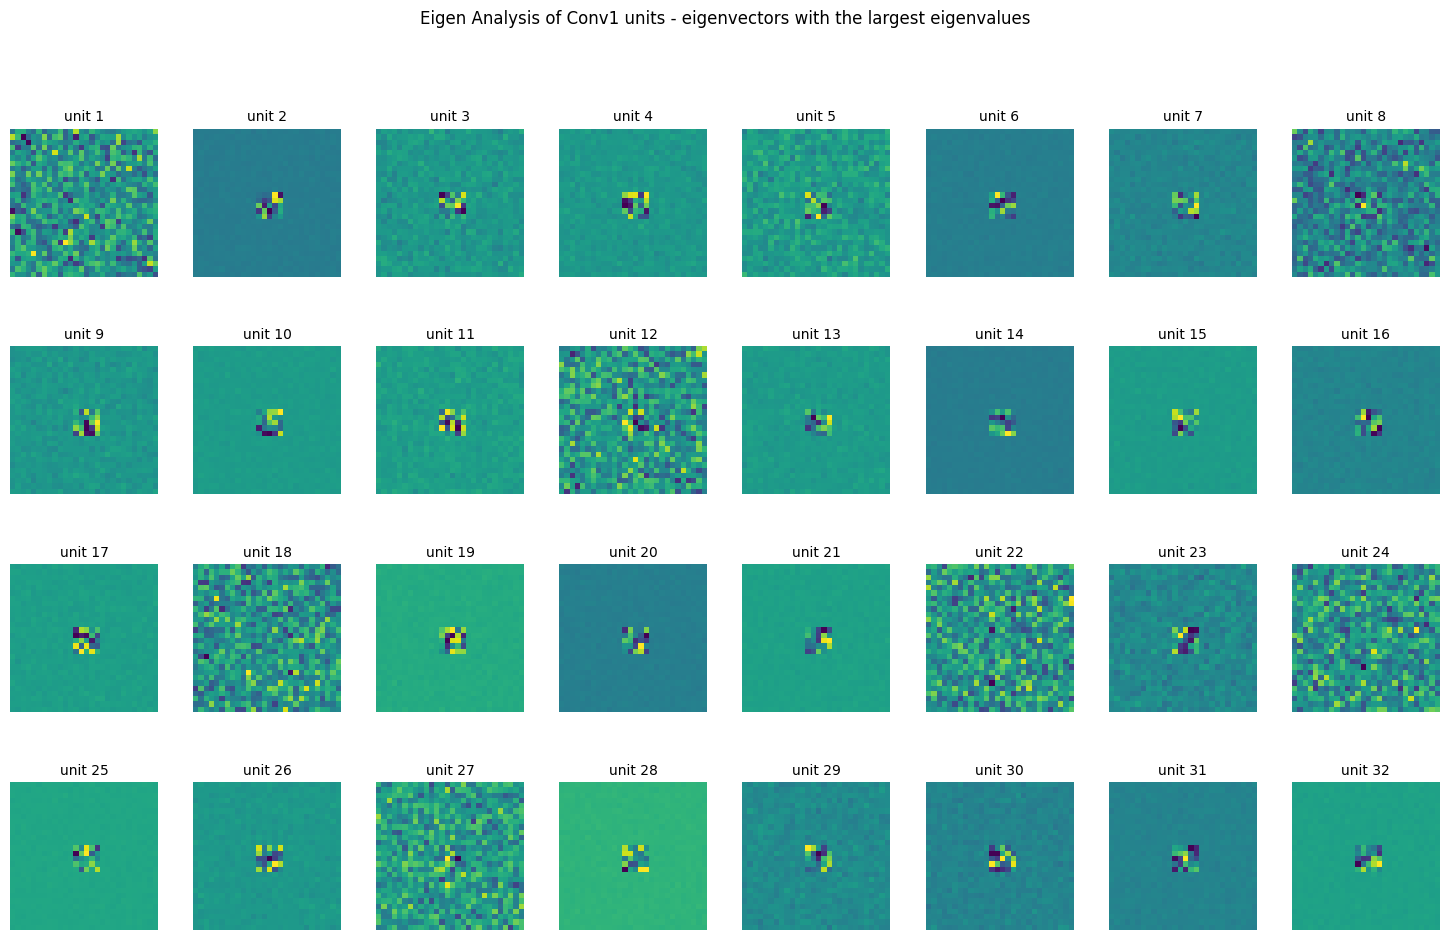

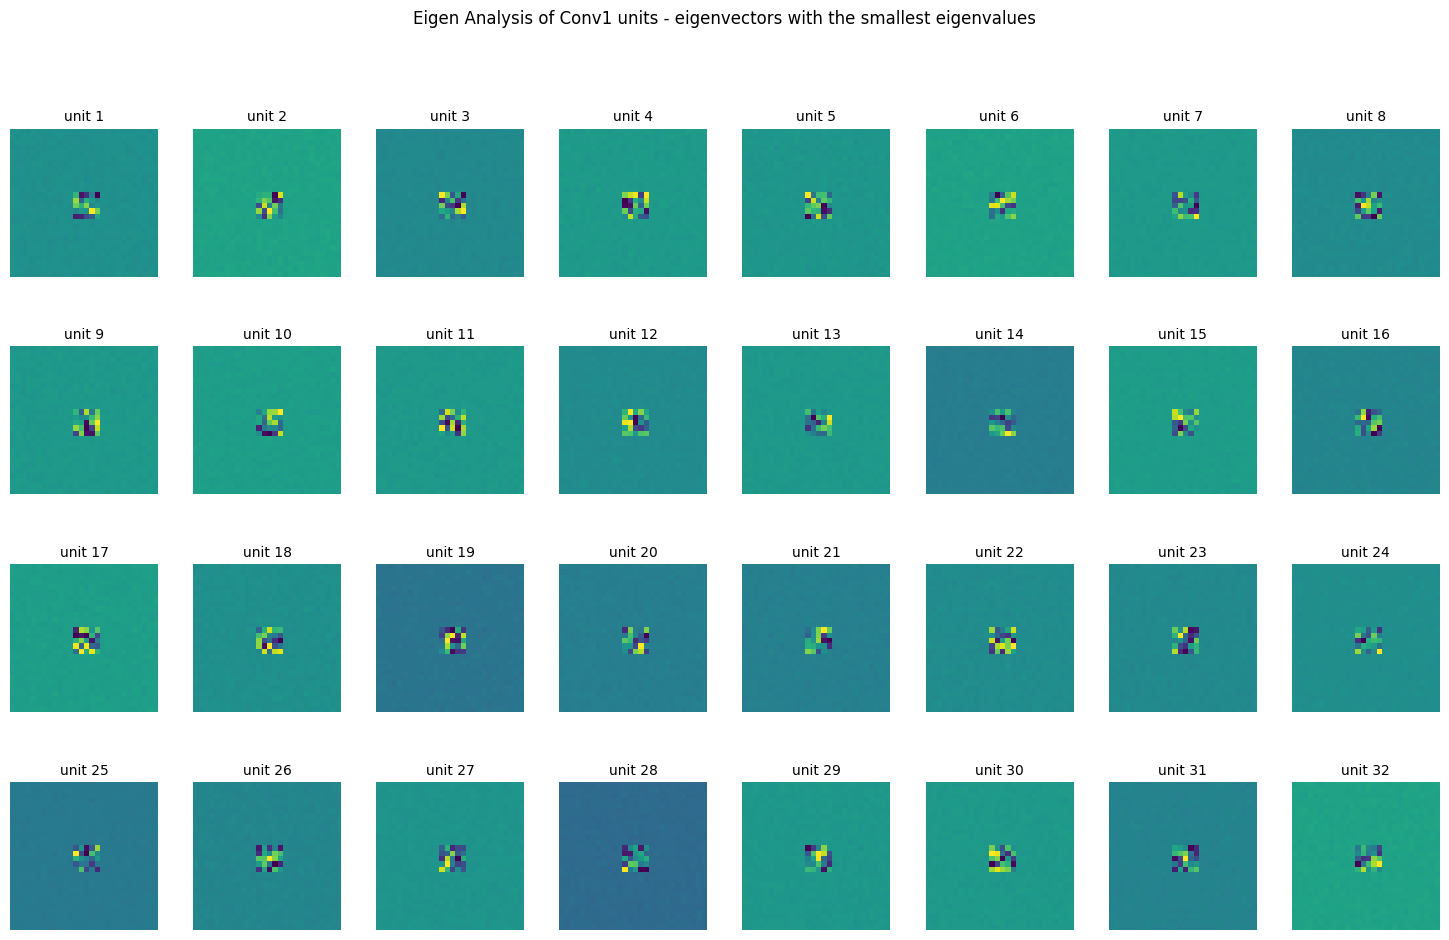

In [50]:
# eigenvectors visualisation - conv1 LARGEST
for i in range(len(eigen1)): # each unit
    to_show = torch.zeros(28, 28)
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        eigenvector = eigen1[i][0][1] # given channel for a given unit
        to_show = eigenvector[:, -1].reshape(28, 28) # select the eigenvector with the largest eigenvalue
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((28, 28)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the largest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

# eigenvectors visualisation - conv1 SMALLEST
for i in range(len(eigen1)): # each unit
    to_show = torch.zeros(28, 28)
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        eigenvector = eigen1[i][0][1] # given channel for a given unit
        # eigenvector = eigenvector * eigen1[i][j].eigenvalues
        to_show = eigenvector[:, 0].reshape(28, 28) # select the eigenvector with the largest eigenvalue
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((28, 28)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the smallest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

# Conv1 - Positive Only [0, 255]

In [66]:
# load existing data if already recorded
act_conv1 = torch.load('./rwa_data/mnist/mnist_rand/act1.pt')
noise1 = torch.load('./rwa_data/mnist/mnist_rand/noise1.pt')
rf1 = torch.load('./rwa_data/mnist/mnist_rand/rf1.pt')

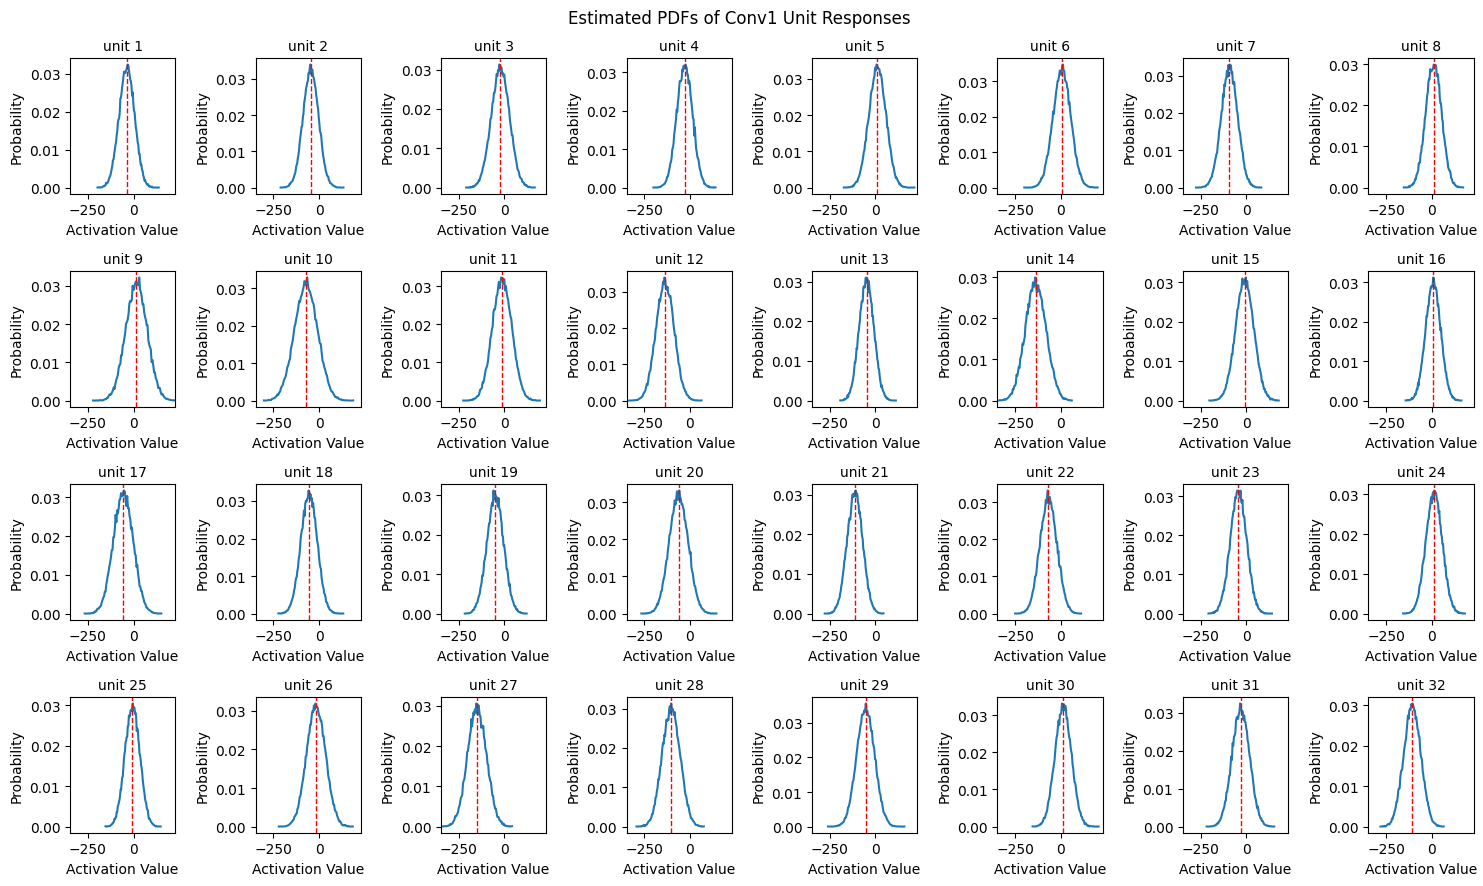

In [23]:
# PDFs of conv1 responses
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 9)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 9)
plt.show()

RWA

In [21]:
# RWA
rf1 = RWA(layer, net, act_conv1, noise1, inputX=28, inputY=28, NBatches=NBatches, BSize=BSize)
# adjust dimensions of rf1 from 3 channels to 1 channel for mnist
rf1 = rf1[:,:,:,0]

100%|██████████| 1600000/1600000 [01:16<00:00, 20981.92it/s]

Shape of receptive field list: torch.Size([32, 28, 28, 3])


In [22]:
# Save the RWA data
torch.save(rf1, './rwa_data/mnist/mnist_rand/rf1.pt')

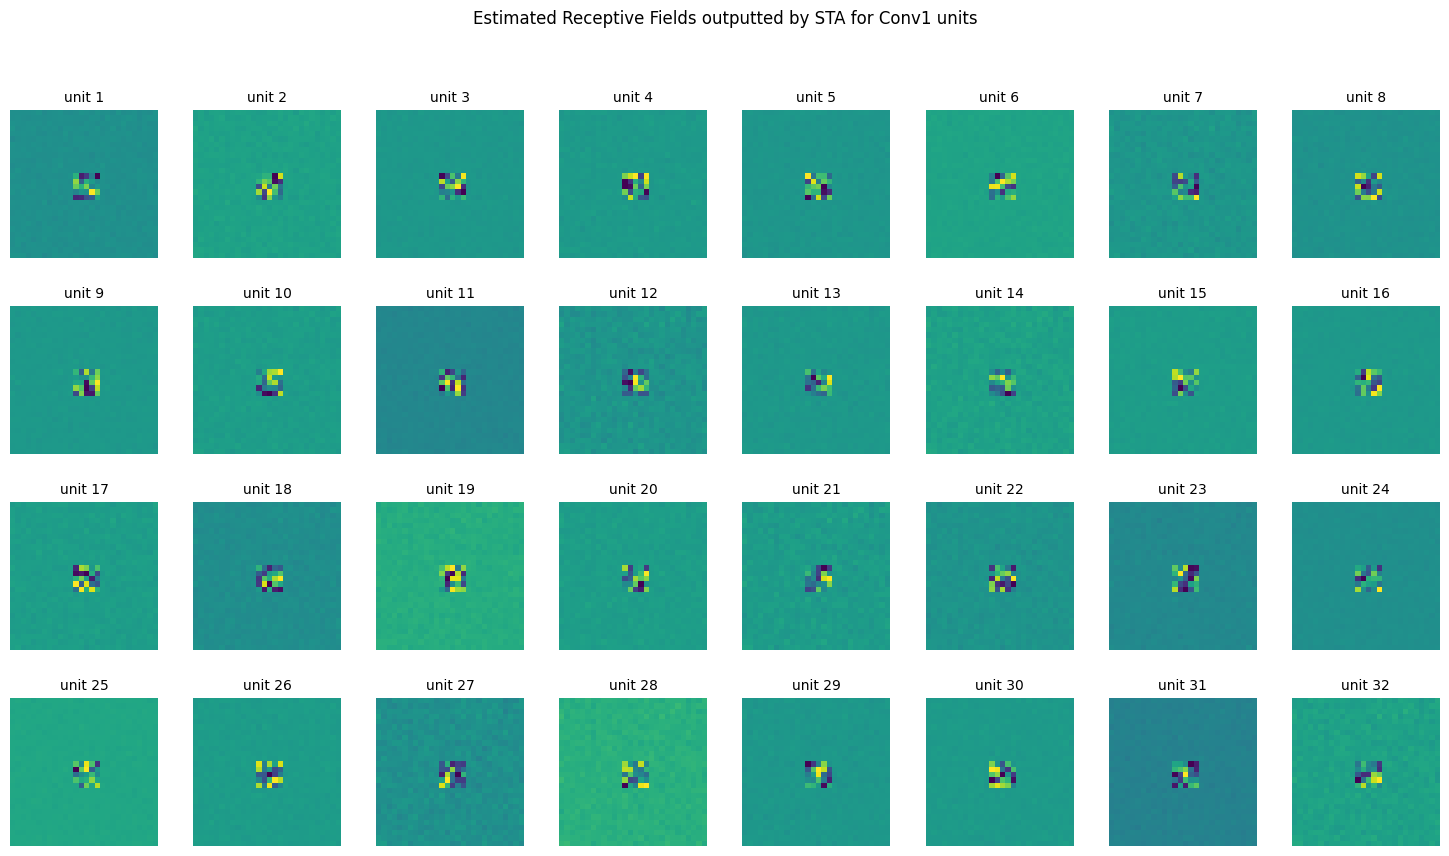

In [24]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 9)
plt.show()

# Conv2 - Zero Mean [-127.5, 127,5]

In [16]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/mnist/mnist_rand_0mean/act2.pt')
noise2 = torch.load('./rwa_data/mnist/mnist_rand_0mean/noise2.pt')
rf2 = torch.load('./rwa_data/mnist/mnist_rand_0mean/rf2.pt')

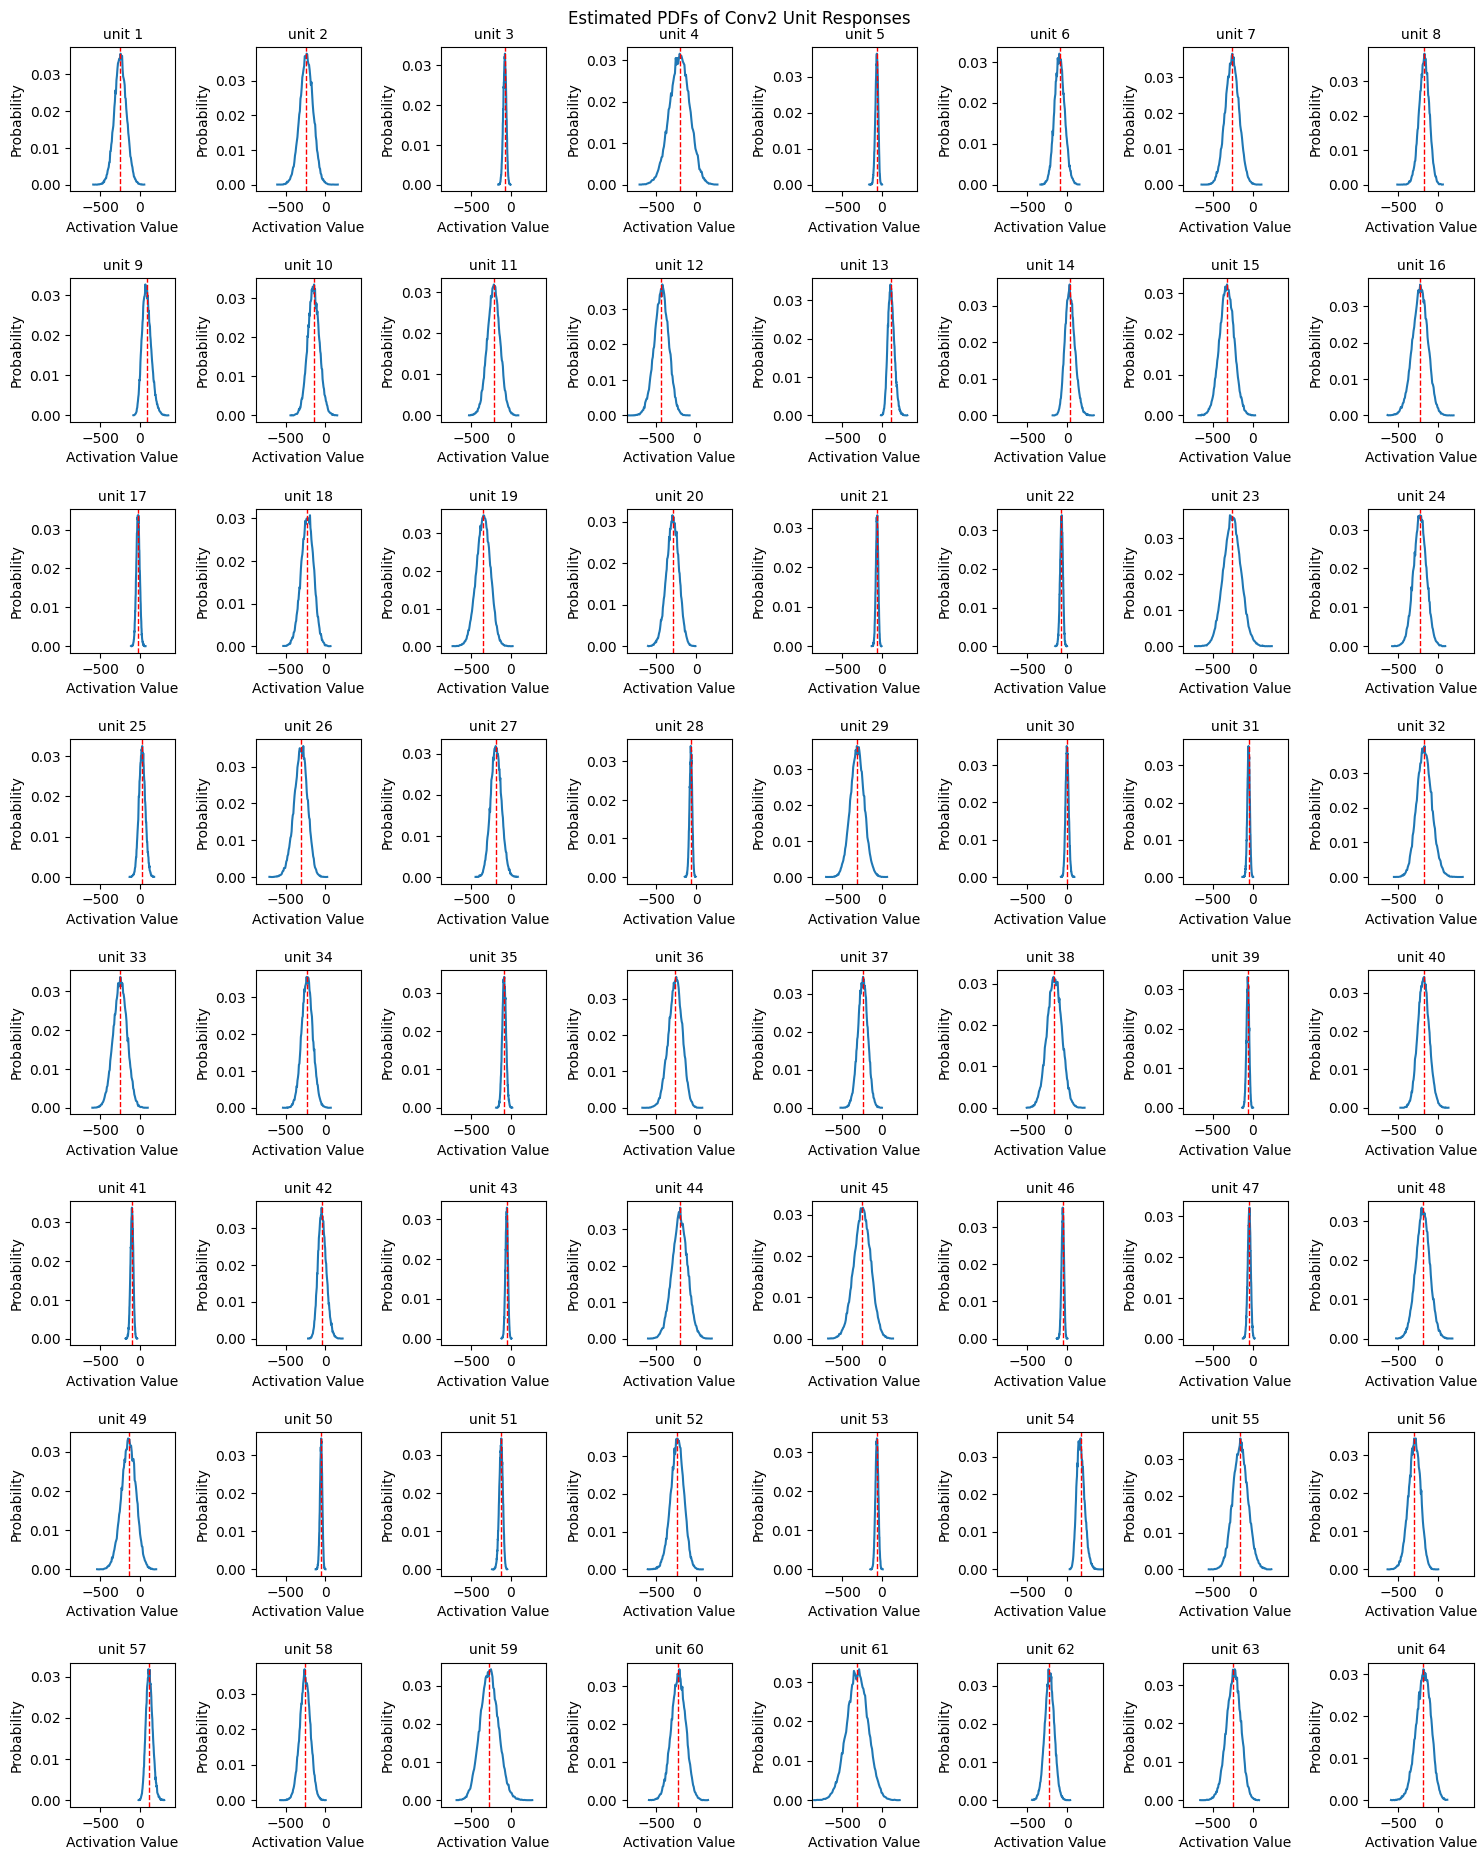

In [9]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 17)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 19)
plt.show()

RWA

In [32]:
# RWA
rf2 = RWA(layer, net, act_conv2, noise2, inputX=28, inputY=28, NBatches=NBatches, BSize=BSize)
# adjust dimensions of rf1 from 3 channels to 1 channel for mnist
rf2 = rf2[:,:,:,0]

100%|██████████| 3200000/3200000 [02:31<00:00, 21145.40it/s]

Shape of receptive field list: torch.Size([64, 28, 28, 3])


In [33]:
# Save the RWA data
torch.save(rf2, './rwa_data/mnist/mnist_rand_0mean/rf2.pt')

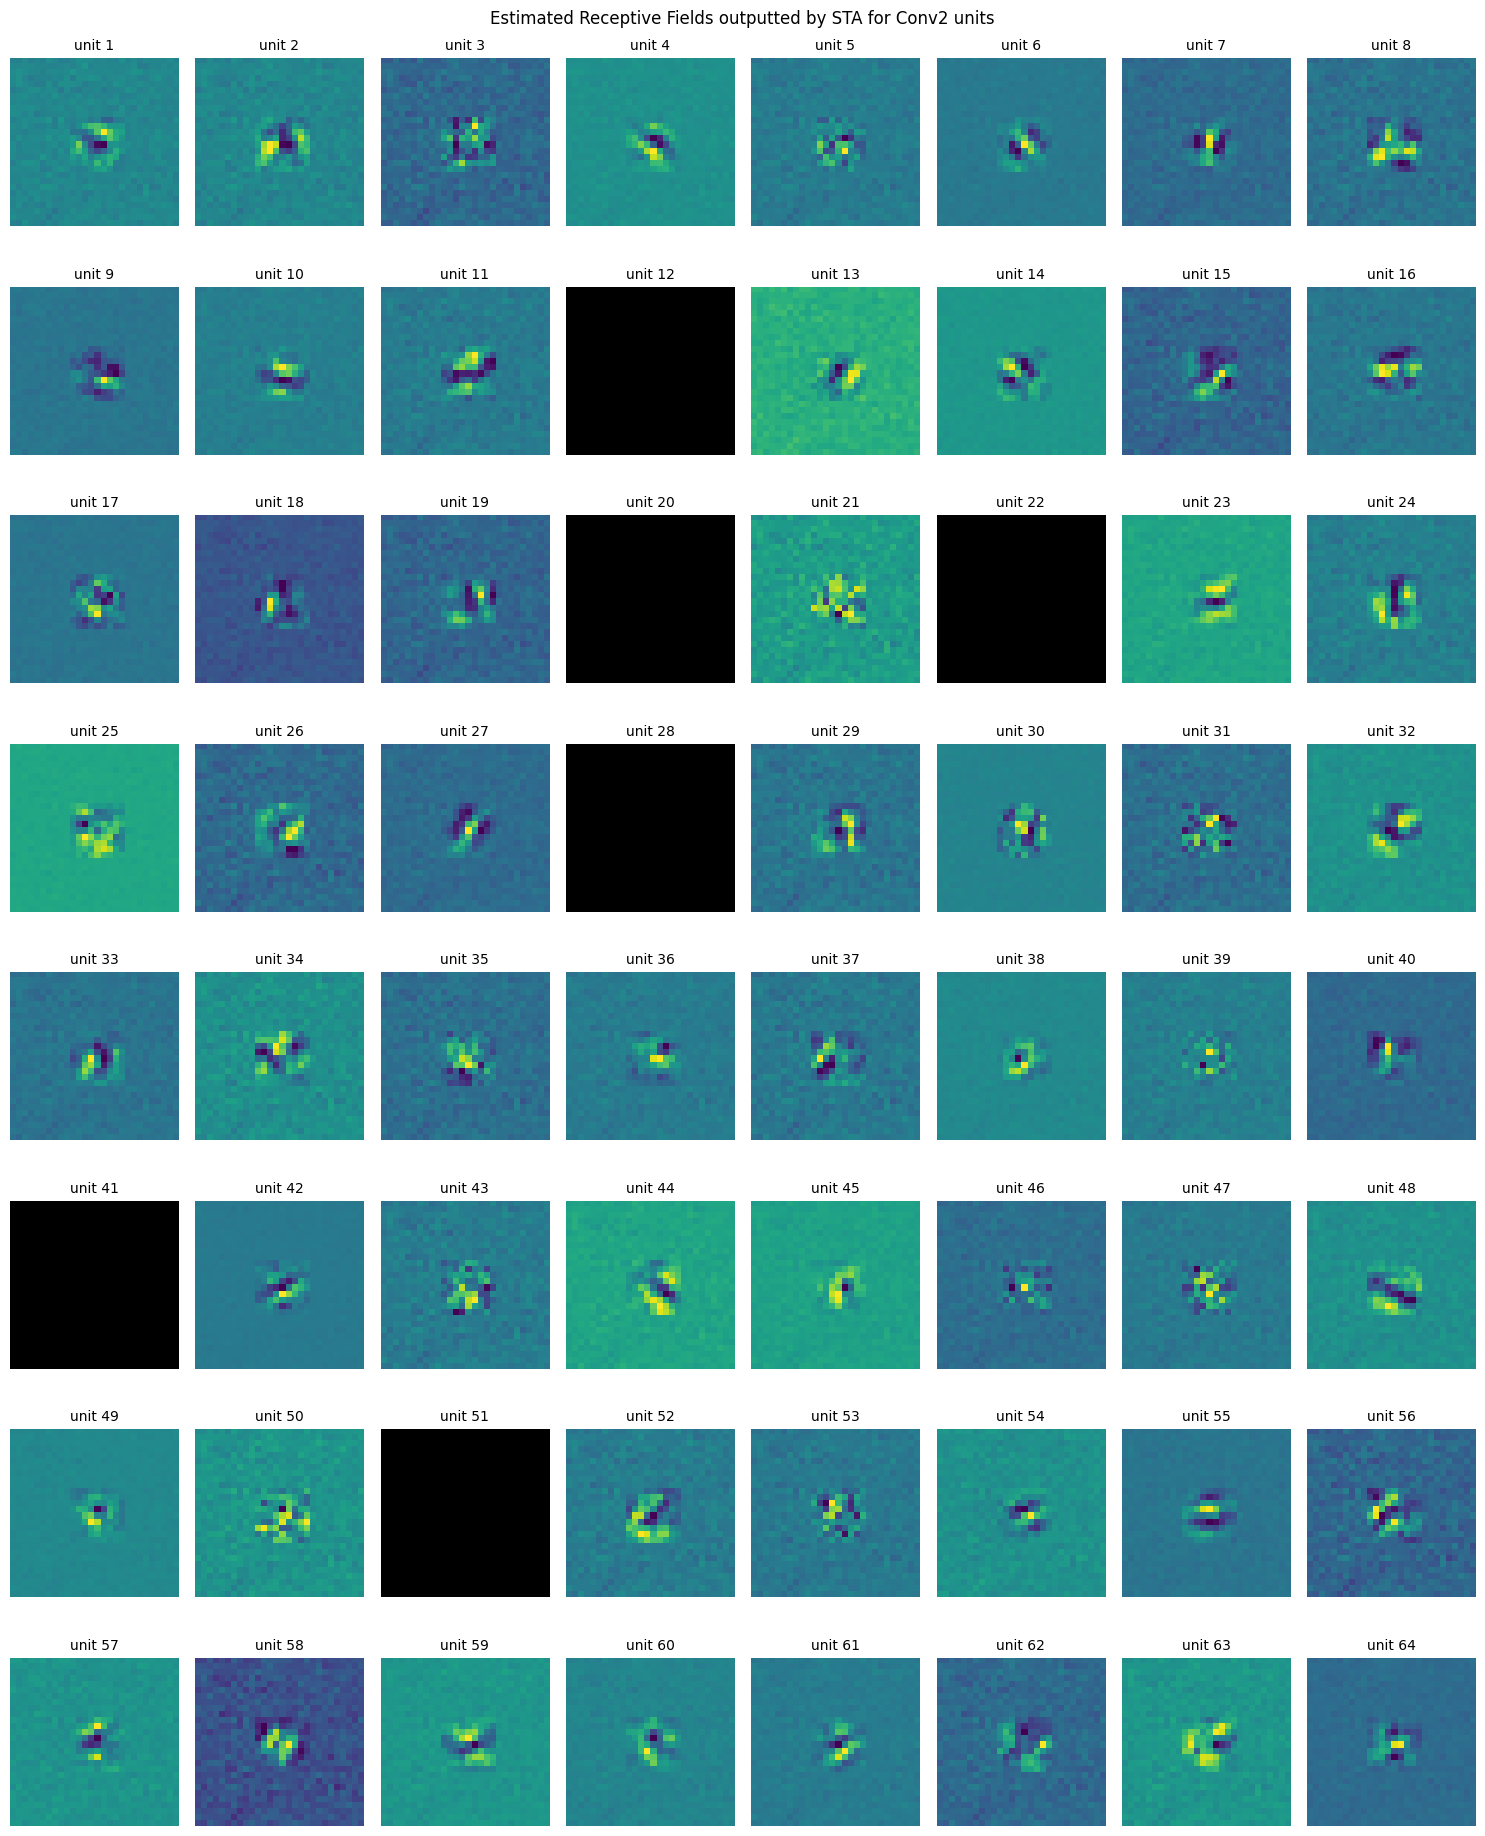

In [10]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(8, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(13, 17)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 19)
plt.show()

Correlation

In [17]:
rf2_cropped = corr_loc(noise2, act_conv2, rf2)

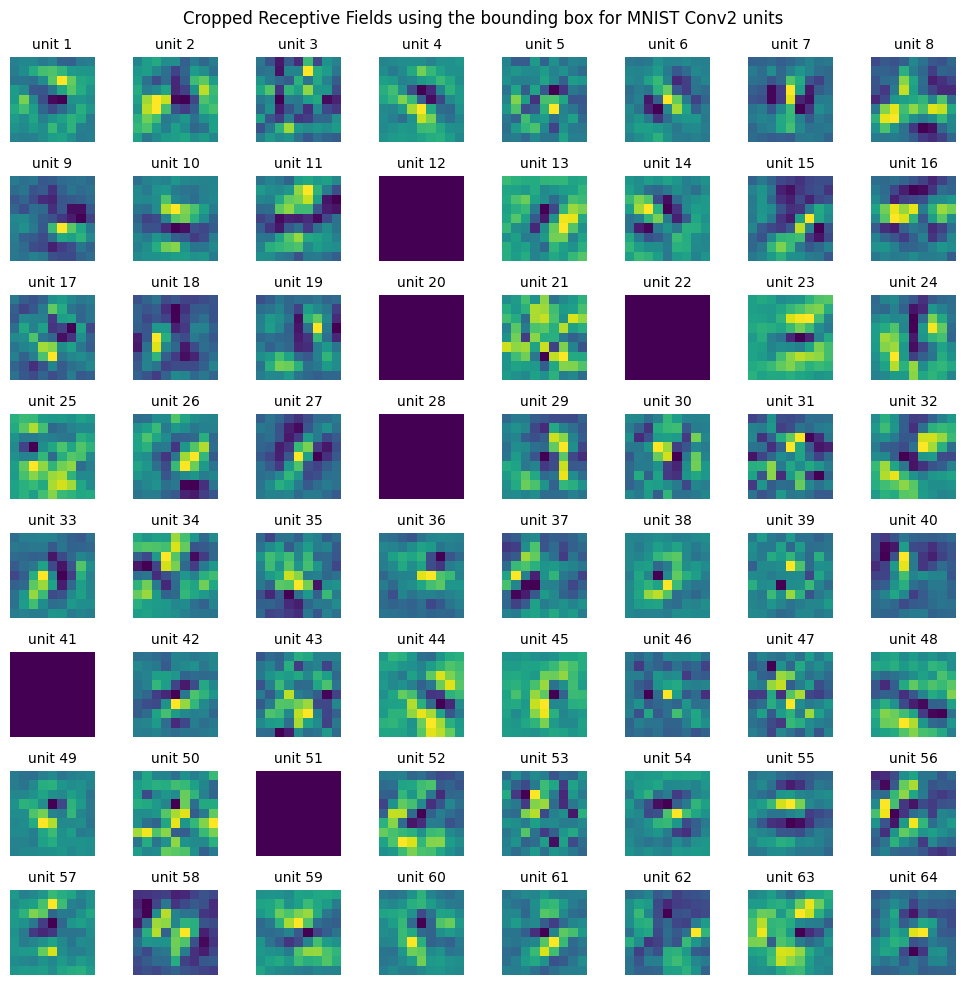

In [20]:
# Visualise the RWA output as image plots
for i in range(rf2_cropped.shape[0]):
    plt.subplot(8, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2_cropped[i]
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 1)))
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(10, 10)

# title for the entire plot
plt.suptitle('Cropped Receptive Fields using the bounding box for MNIST Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(10, 10)
plt.show()

RWC

In [ ]:
# load existing data if already recorded
cov2 = torch.load('./rwa_data/mnist/mnist_rand_0mean/cov2.pt')
eigen2 = torch.load('./rwa_data/mnist/mnist_rand_0mean/eigen2.pt')

In [9]:
# RWC
cov2 = RWC_mnist(layer, net, act_conv2, noise2, rf2, NBatches=NBatches, BSize=BSize, zeroMean=True)

Shape of reshaped receptive field list: torch.Size([64, 784, 1])
Shape of reshaped noise list: torch.Size([50000, 784, 1])


  0%|          | 0/3200000 [00:00<?, ?it/s]

100%|██████████| 3200000/3200000 [45:37:31<00:00, 19.48it/s]       

Shape of covariance matrix list: torch.Size([64, 784, 784, 1])


# Conv2 - Positive Only [0, 255]

In [53]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/mnist/mnist_rand/act2.pt')
noise2 = torch.load('./rwa_data/mnist/mnist_rand/noise2.pt')
rf2 = torch.load('./rwa_data/mnist/mnist_rand/rf2.pt')

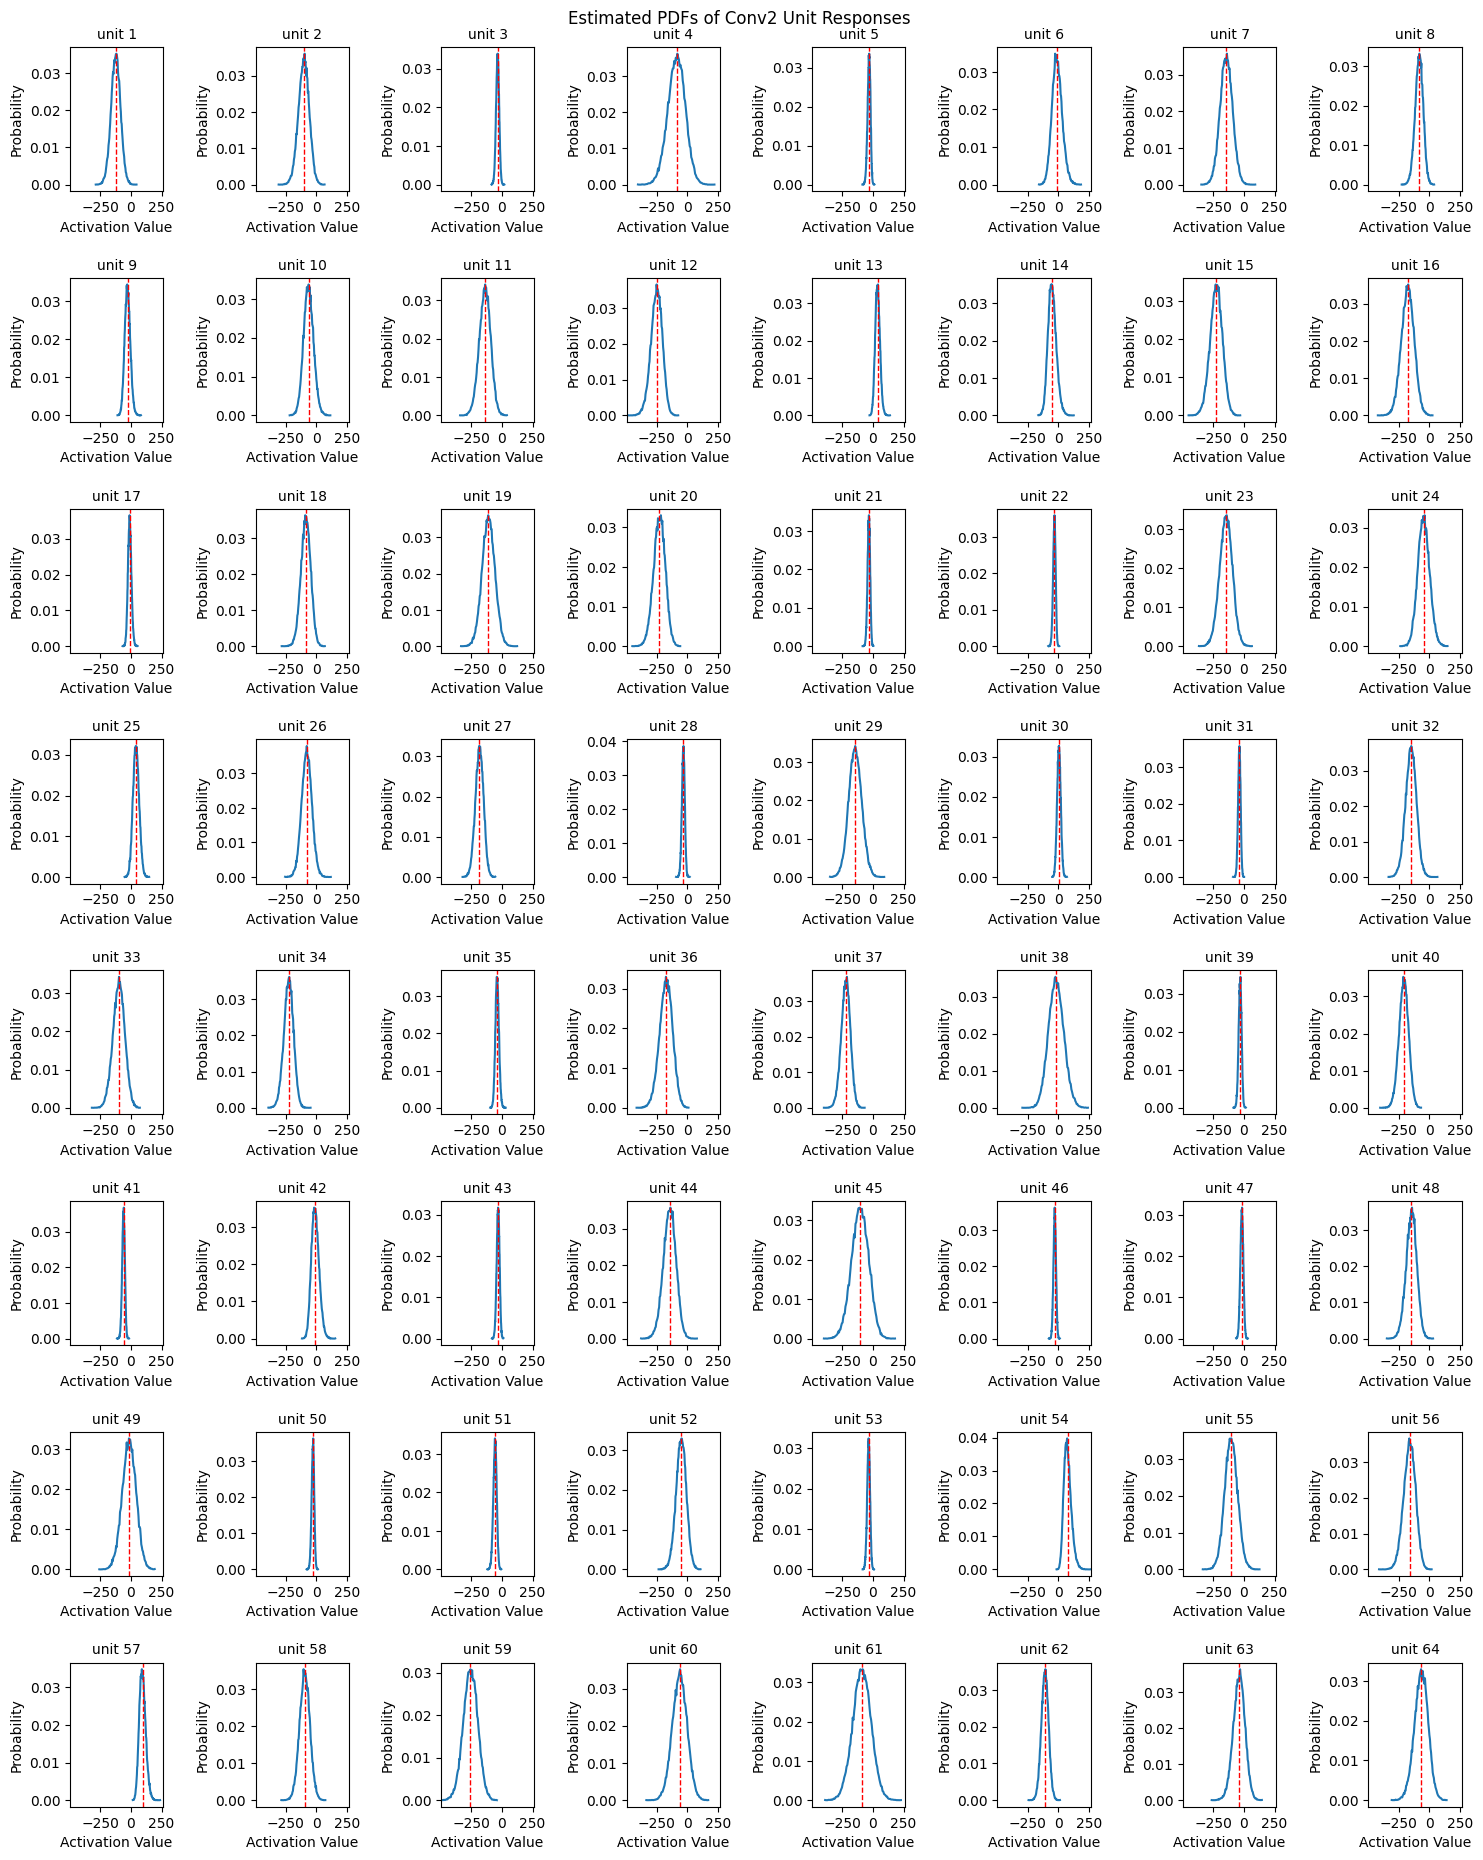

In [42]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 17)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 19)
plt.show()

RWA

In [39]:
# RWA
rf2 = RWA(layer, net, act_conv2, noise2, inputX=28, inputY=28, NBatches=NBatches, BSize=BSize)
# adjust dimensions of rf1 from 3 channels to 1 channel for mnist
rf2 = rf2[:,:,:,0]

100%|██████████| 3200000/3200000 [02:33<00:00, 20827.54it/s]

Shape of receptive field list: torch.Size([64, 28, 28, 3])


In [41]:
# Save the RWA data
torch.save(rf2, './rwa_data/mnist/mnist_rand/rf2.pt')

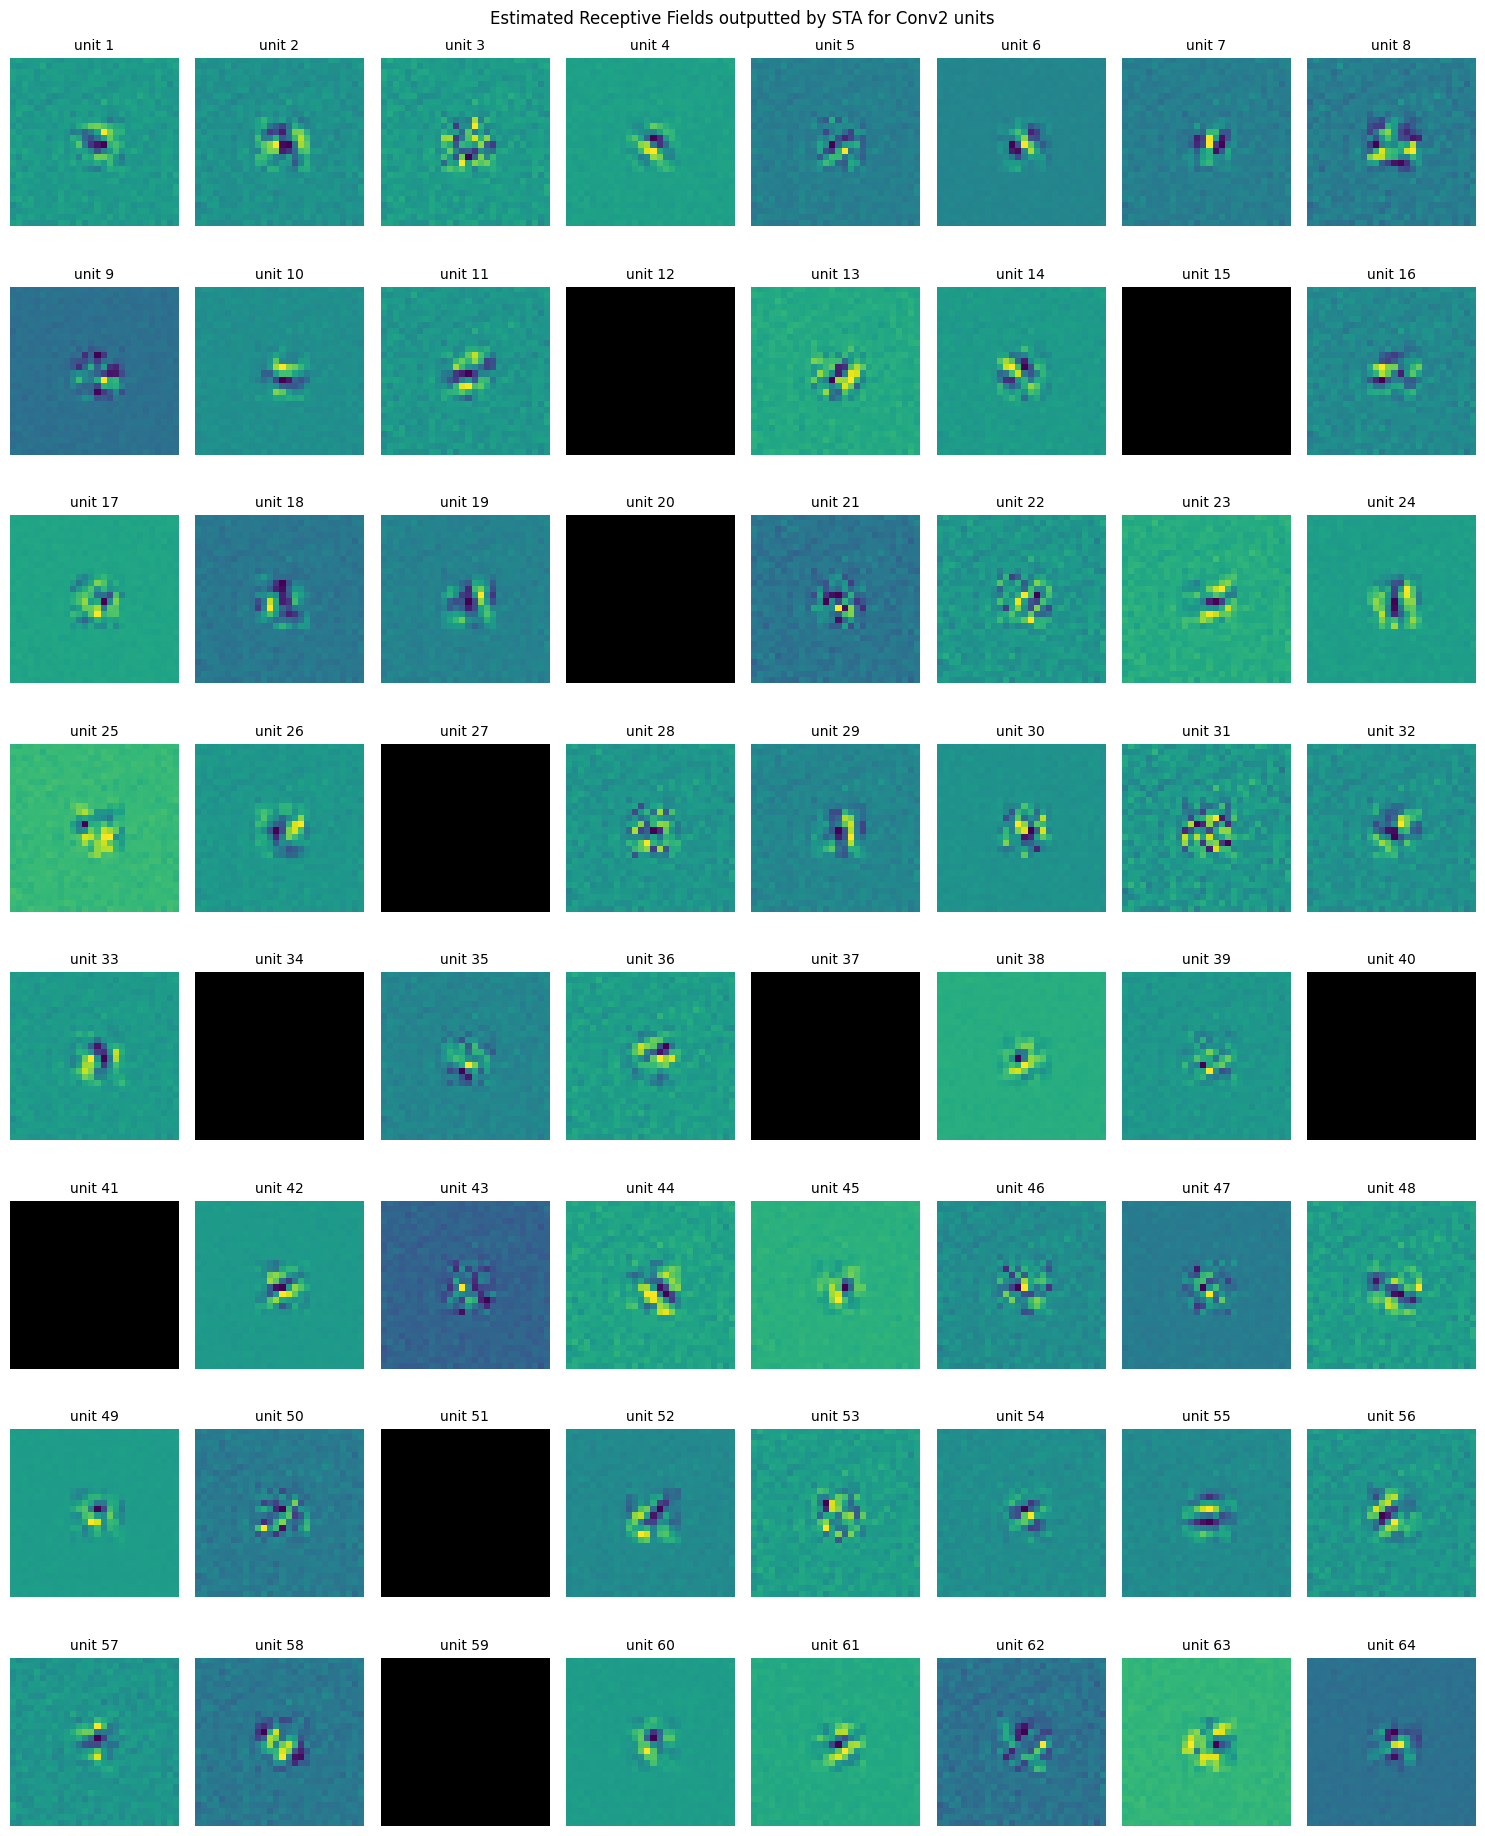

In [43]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(8, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(13, 17)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 19)
plt.show()